In [1]:
# results obtained from E1
degree = 3
compression_rate = 0.3

In [2]:
%%time
from utils.data import load_ucr_data_short, load_ucr_dataset, load_ucr_data_short_and_medium

# load data
#data = load_ucr_data_short()
data = load_ucr_dataset(48)
print("number of time series:", len(data.index))

number of time series: 208
CPU times: total: 859 ms
Wall time: 955 ms


In [3]:
from utils.plot import add_fitted_curve_to_plot


def fit_spline(method: str, ts: [(float, float)], knots: [float], num_coeffs: int, num_outliers_removed: int,
               degree=None, plot=False,axis = None):
    match method:
        case 'PAA':
            color = 'tab:gray'
            degree = 0
            _, result = fit_max_spline(ts, knots, degree)
            fitted_curve = [evaluate_spline(knots, result, degree, x[0]) for x in ts]

        case 'PLA':
            color = 'tab:olive'
            degree = 1
            _, result = fit_max_spline(ts, knots, degree)
            fitted_curve = [evaluate_spline(knots, result, degree, x[0]) for x in ts]

        case 'L8':
            color = 'tab:pink'
            if degree is None:
                degree = 3

            _, result = fit_max_spline(ts, knots, degree)
            fitted_curve = [evaluate_spline(knots, result, degree, x[0]) for x in ts]

        case 'L8 and L1':
            color = 'tab:blue'
            if degree is None:
                degree = 3

            eps = 2e-7
            _, result = fit_max_l1_spline(ts, knots, degree, eps=eps)
            fitted_curve = [evaluate_spline(knots, result, degree, x[0]) for x in ts]

        case 'DFT':
            color = 'tab:green'
            result = fit_DFT(ts, num_coeffs)
            fitted_curve = calculate_inverse_DFT(len(ts), num_coeffs, result)

        case 'LSQ':
            color = 'tab:purple'
            if degree is None:
                degree = 3

            if num_outliers_removed > 0:
                num_xs = len(ts) + num_outliers_removed
                num_coeffs = generate_coeff_counts(num_xs, degree, [compression_rate])[0]
                knots = generate_knot_vector_from_coeff_count(degree=degree, num_coeffs=num_coeffs)
                xs = np.linspace(0, 1, num=num_xs)
                ts = replace_outliers(ts_without_outliers=ts, original_xs=xs)

            result = fit_LSQ_spline(time_series=ts, knots=knots, degree=degree)
            fitted_curve = [evaluate_spline(knots, result, degree, x[0]) for x in ts]

    max_dist = np.max(np.abs(np.array(fitted_curve) - np.array([x[1] for x in ts])))
    mse = mean_squared_error(fitted_curve, [x[1] for x in ts])
    mae = mean_absolute_error(fitted_curve, [x[1] for x in ts])

    """if plot & (axis is not None):
        add_fitted_curve_to_plot(axis, fitted_curve, max_dist, color=color, label=method)"""
    
    if plot:
        if axis is not None:
            add_fitted_curve_to_plot(axis, fitted_curve, max_dist, color=color, label=method)
        else:
            add_fitted_curve_to_plot(plt, fitted_curve, max_dist, color=color, label=method)
            

    return {'max_dist': max_dist,
            'MSE': mse,
            'MAE': mae}


GestureMidAirD3 no. 0, 0.0% processed
len(ts): 180
with outliers: len(ts): 180 len(knots) 58
len(ts): 161
without outliers: len(ts): 161 len(knots) 52


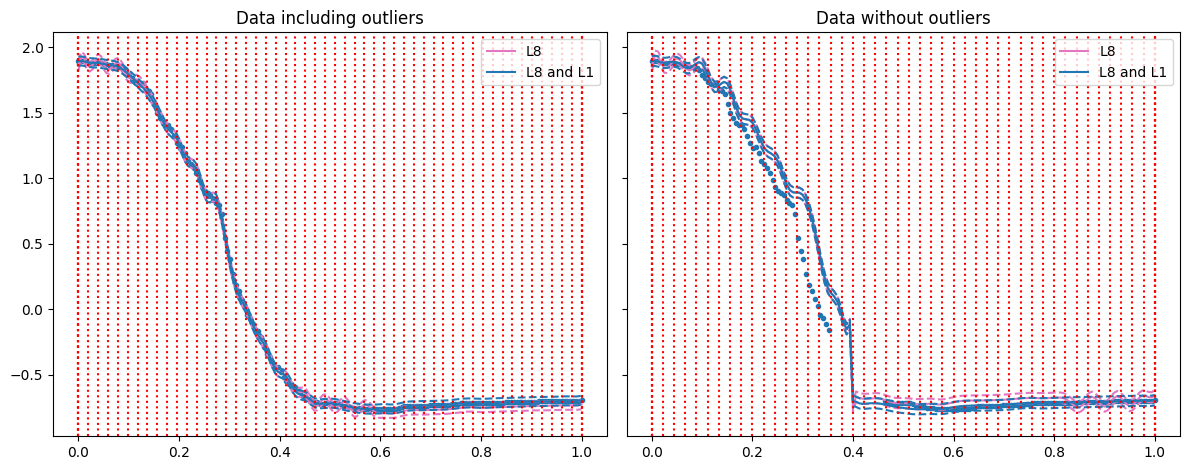

GestureMidAirD3 no. 1, 0.5% processed
len(ts): 90
with outliers: len(ts): 90 len(knots) 31
len(ts): 78
without outliers: len(ts): 78 len(knots) 27


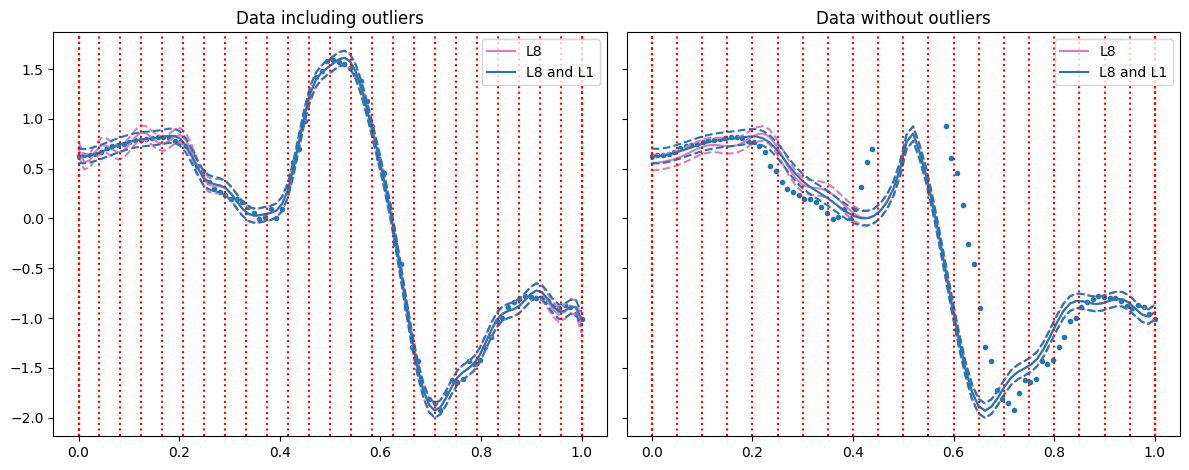

GestureMidAirD3 no. 2, 1.0% processed
len(ts): 120
with outliers: len(ts): 120 len(knots) 40
len(ts): 89
without outliers: len(ts): 89 len(knots) 30


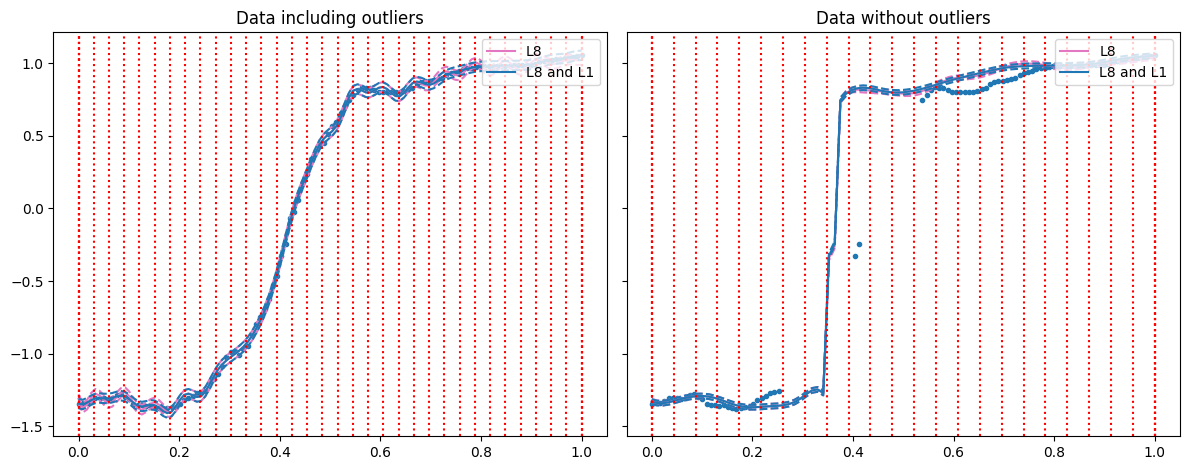

GestureMidAirD3 no. 3, 1.4% processed
len(ts): 240
with outliers: len(ts): 240 len(knots) 76
len(ts): 214
without outliers: len(ts): 214 len(knots) 68


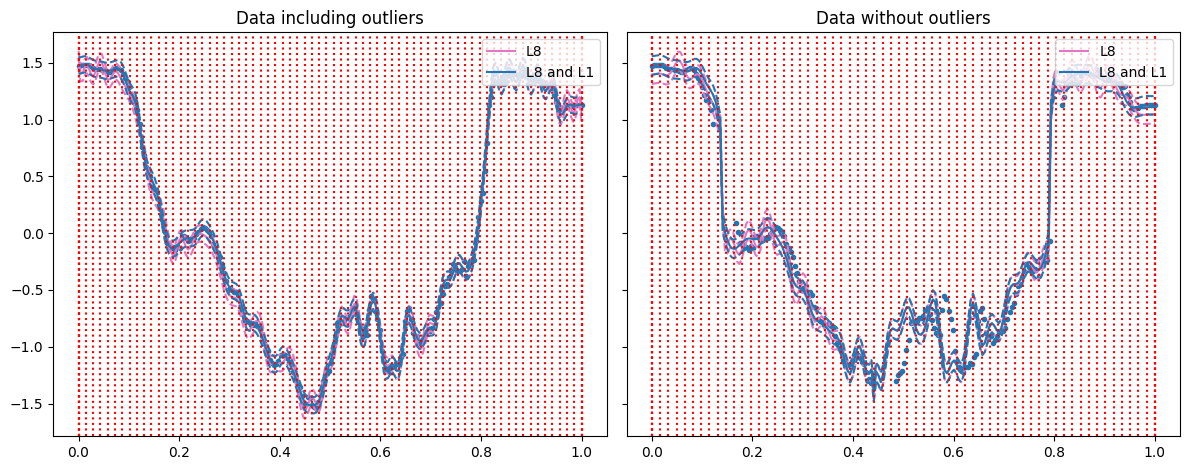

GestureMidAirD3 no. 4, 1.9% processed
len(ts): 238
with outliers: len(ts): 238 len(knots) 75
len(ts): 218
without outliers: len(ts): 218 len(knots) 69


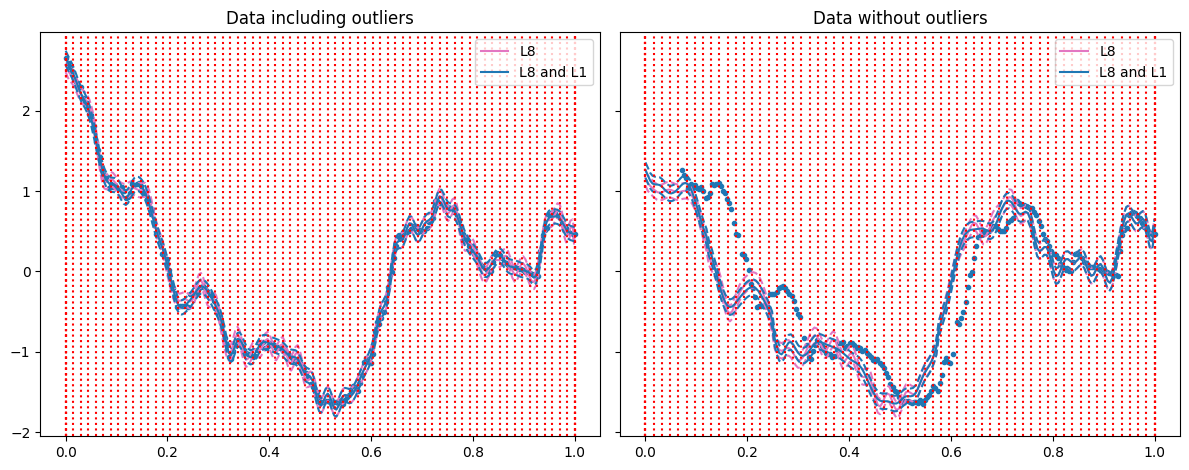

GestureMidAirD3 no. 5, 2.4% processed
len(ts): 90
with outliers: len(ts): 90 len(knots) 31
len(ts): 74
without outliers: len(ts): 74 len(knots) 26


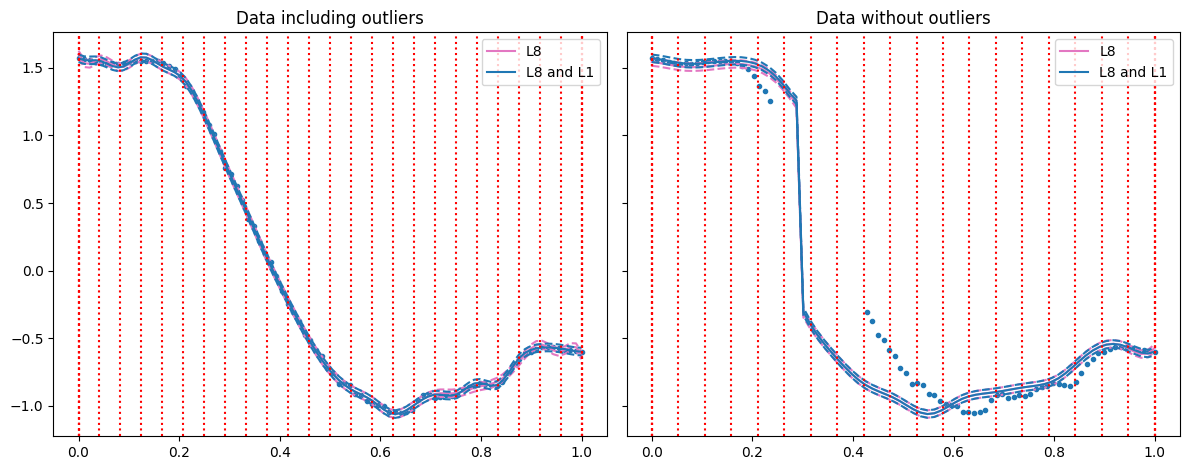

GestureMidAirD3 no. 6, 2.9% processed
len(ts): 360
with outliers: len(ts): 360 len(knots) 112
len(ts): 293
without outliers: len(ts): 293 len(knots) 91


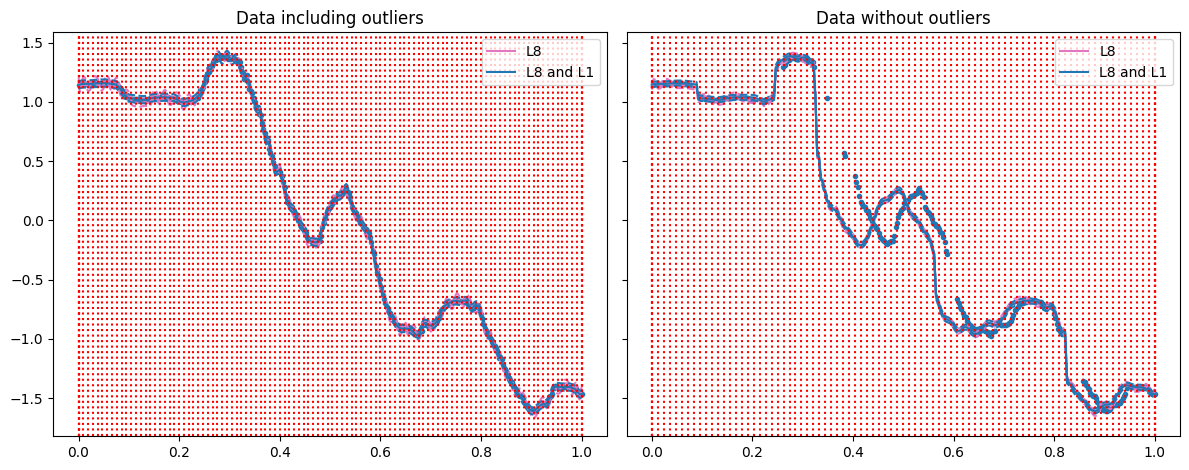

GestureMidAirD3 no. 7, 3.4% processed
len(ts): 120
with outliers: len(ts): 120 len(knots) 40
len(ts): 97
without outliers: len(ts): 97 len(knots) 33


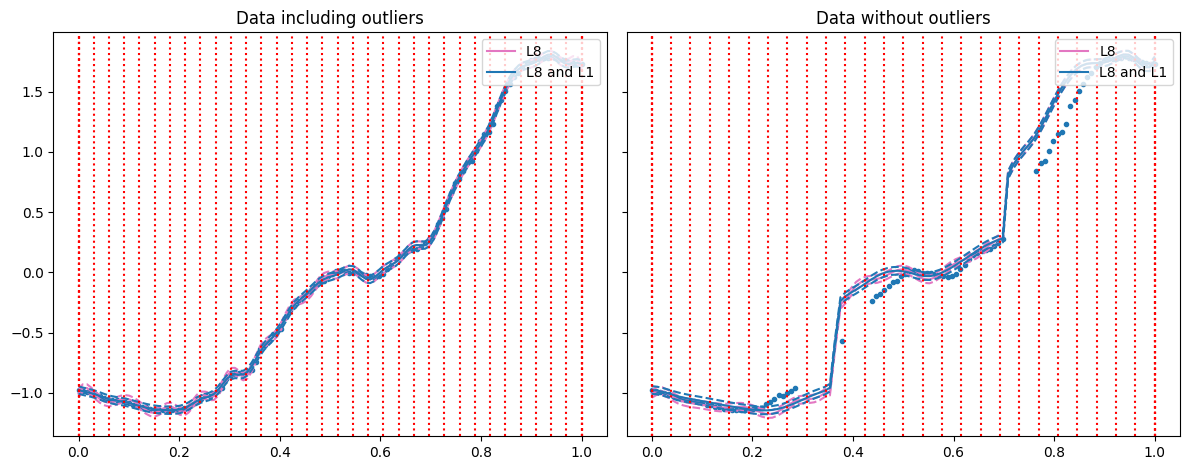

GestureMidAirD3 no. 8, 3.8% processed
len(ts): 180
with outliers: len(ts): 180 len(knots) 58
len(ts): 139
without outliers: len(ts): 139 len(knots) 45


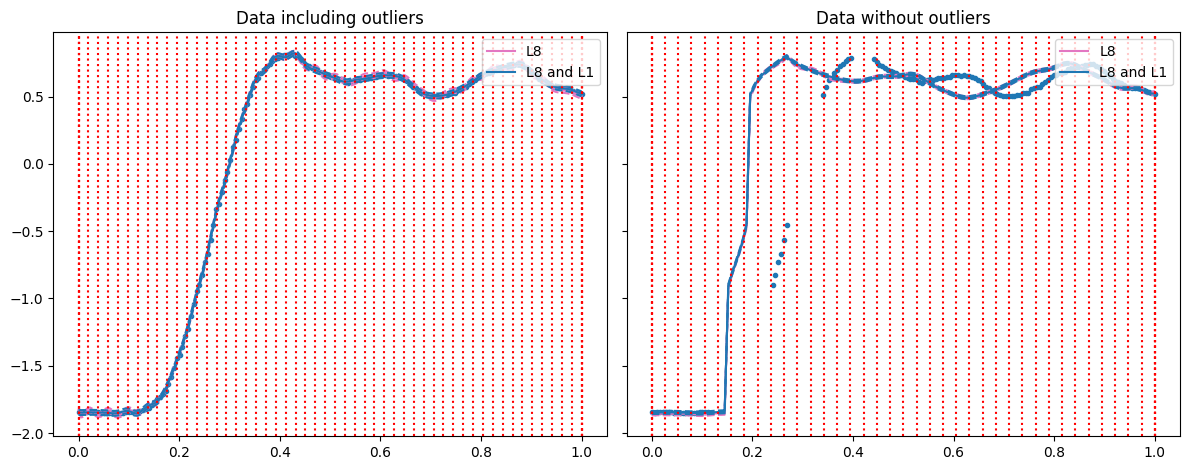

GestureMidAirD3 no. 9, 4.3% processed
len(ts): 169
with outliers: len(ts): 169 len(knots) 54
len(ts): 138
without outliers: len(ts): 138 len(knots) 45


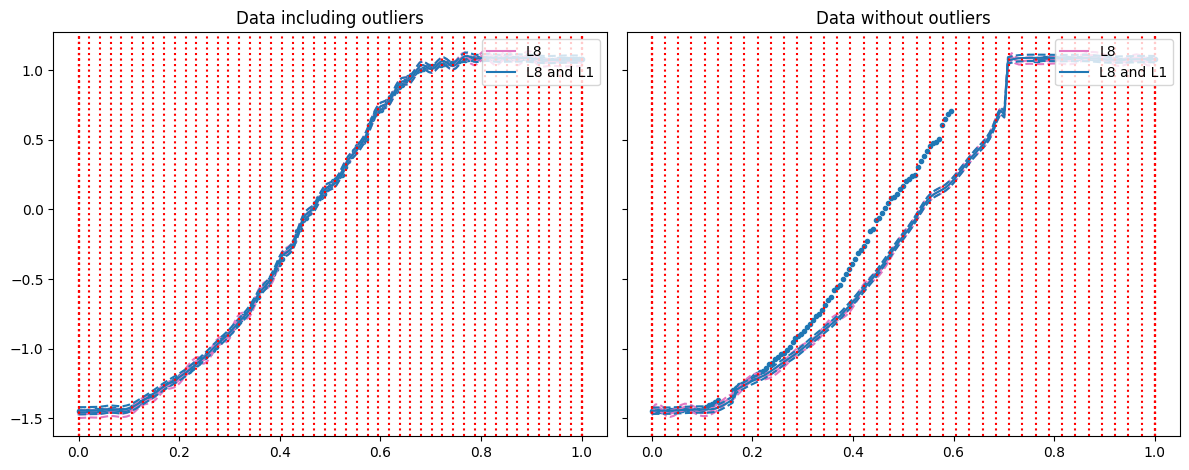

GestureMidAirD3 no. 10, 4.8% processed
len(ts): 179
with outliers: len(ts): 179 len(knots) 57
len(ts): 139
without outliers: len(ts): 139 len(knots) 45


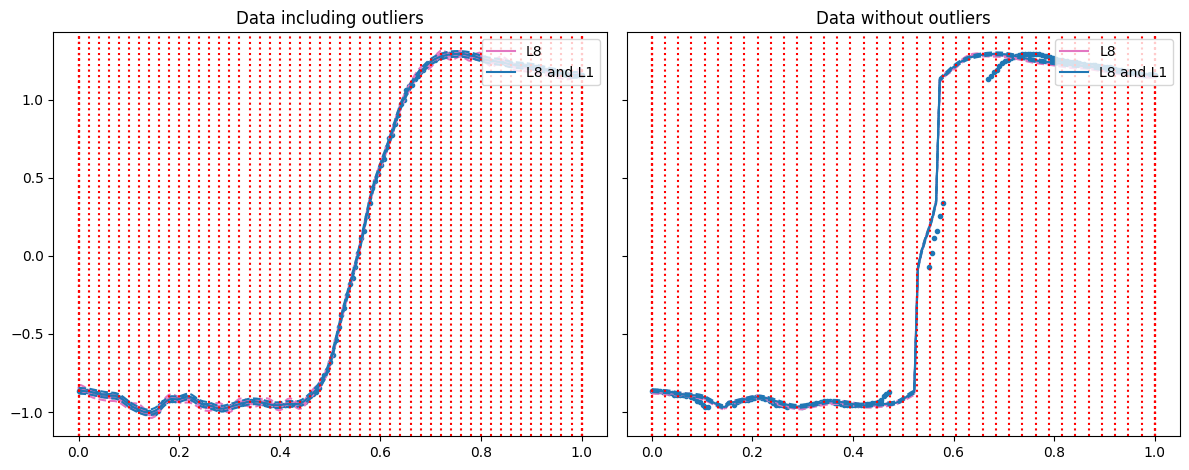

GestureMidAirD3 no. 11, 5.3% processed
len(ts): 180
with outliers: len(ts): 180 len(knots) 58
len(ts): 150


KeyboardInterrupt: 

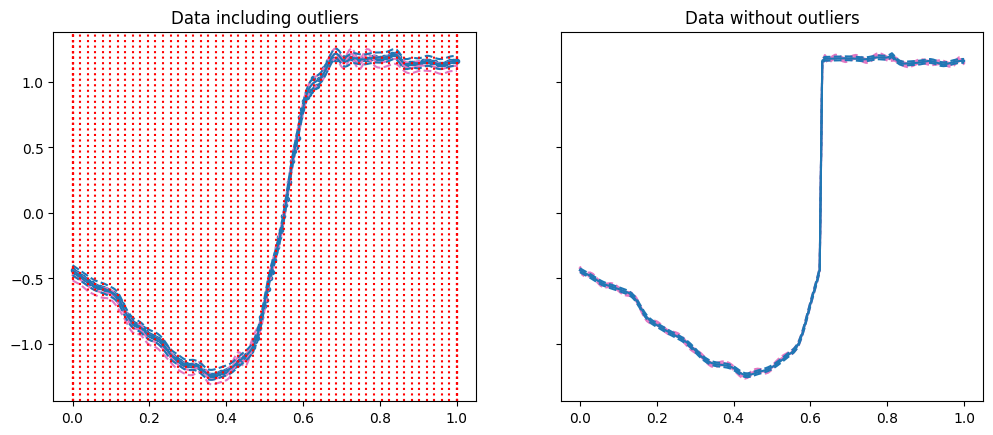

In [4]:
from utils.data import remove_outliers, replace_outliers
from utils.spline import generate_coeff_counts, generate_knot_vector_from_coeff_count
from utils.fit import fit_max_spline, fit_max_l1_spline, fit_DFT, calculate_inverse_DFT, fit_LSQ_spline
from sklearn.metrics import mean_squared_error, mean_absolute_error
from utils.spline import evaluate_spline
import numpy as np
import matplotlib.pyplot as plt

results = []
num_rows = len(data.index)

for idx, row in data.iterrows():
    original_time_series = row['data']
    time_series_lof = remove_outliers(row['data'])
    print(f"{row['dataset']} no. {row['num']}, {round(idx / num_rows * 100, 1)}% processed")

    f, axes = plt.subplots(1, 2, sharey=True)
    f.set_figwidth(12)

    axes[0].set_title("Data including outliers")
    axes[1].set_title("Data without outliers")

    for ts in [original_time_series, time_series_lof]:
        print("len(ts):", len(ts))
        num_outliers_removed = len(original_time_series) - len(ts)

        num_coeffs = generate_coeff_counts(len(ts), degree, compression_ratios=[compression_rate])[0]
        knots = generate_knot_vector_from_coeff_count(degree=degree, num_coeffs=num_coeffs)

        #fig,ax = plt.subplots()

        for method in ['L8', 'L8 and L1', 'LSQ', 'PAA', 'PLA', 'DFT']:
            #metrics = fit_spline(method, ts, knots, num_coeffs, num_outliers_removed)

            plot_method = False

            if method in ['L8', 'L8 and L1']:  #, 'LSQ']:
                plot_method = True

            if num_outliers_removed > 0:
                axis = axes[1]
            else:
                axis = axes[0]

            metrics = fit_spline(method, ts, knots, num_coeffs, num_outliers_removed, plot=plot_method, axis=axis)

            results.append({
                'dataset': row['dataset'],
                'num': row['num'],
                'num_data_pts': len(ts),
                'num_outliers_removed': num_outliers_removed,
                'num_coeffs': num_coeffs,
                'method': method,
                'max_dist': metrics['max_dist'],
                'MSE': metrics['MSE'],
                'MAE': metrics['MAE']
                #'mean_diff': mean_diff(ts)
            })

        #ax.legend()
        #ax.set_xlabel('X-axis')
        #ax.set_ylabel('Y-axis')
        #ax.set_title('Multiple Plots on the Same Figure')

        if num_outliers_removed > 0:
            axes[1].scatter([d[0] for d in ts], [d[1] for d in ts], marker='.')

            for knot in knots:
                axes[1].axvline(x=knot, color='r', linestyle='dotted')
                
            print("without outliers: len(ts):", len(ts), "len(knots)", len(knots))


        else:
            axes[0].scatter([d[0] for d in ts], [d[1] for d in ts], marker='.')

            #for knot in knots:
                #axes[0].axvline(x=knot, color='tab:gray', linestyle='dotted')

            print("with outliers: len(ts):", len(ts), "len(knots)", len(knots))



    plt.subplots_adjust(bottom=0.25, top=0.95)
    axes[0].legend(loc='upper right')
    axes[1].legend(loc='upper right')
    plt.tight_layout()
    plt.show()


In [ ]:
import pandas as pd

#pd.set_option('display.float_format', '{:.10f}'.format)
e2_results = pd.DataFrame(results)
e2_results.drop_duplicates()
mean_values = e2_results.groupby('method').agg({'max_dist': 'mean', 'MSE': 'mean', 'MAE': 'mean'}).reset_index()
mean_values

In [ ]:
import pandas as pd

#pd.set_option('display.float_format', '{:.10f}'.format)
e2_results = pd.DataFrame(results)
e2_results.drop_duplicates()
# Calculate mean values for each accuracy measure separately
mean_max_dist = e2_results.groupby('method')['max_dist'].mean().reset_index()
mean_mse = e2_results.groupby('method')['MSE'].mean().reset_index()
mean_mae = e2_results.groupby('method')['MAE'].mean().reset_index()

# Merge the mean values into a single DataFrame
mean_values = mean_max_dist.merge(mean_mse, on='method').merge(mean_mae, on='method')
mean_values

In [ ]:
df_no_outliers = e2_results[e2_results['num_outliers_removed'] > 0]
df_with_outliers = e2_results[e2_results['num_outliers_removed'] == 0]

mean_values_no_outliers = df_no_outliers.groupby('method').agg(
    {'max_dist': 'mean', 'MSE': 'mean', 'MAE': 'mean'}).reset_index()
mean_values_no_outliers.rename(columns={'max_dist': 'max_dist w/o o.', 'MSE': 'MSE w/o o.', 'MAE': 'MAE w/o o.'},
                               inplace=True)

mean_values_with_outliers = df_with_outliers.groupby('method').agg(
    {'max_dist': 'mean', 'MSE': 'mean', 'MAE': 'mean'}).reset_index()
mean_values_with_outliers.rename(columns={'max_dist': 'max_dist', 'MSE': 'MSE', 'MAE': 'MAE'}, inplace=True)

mean_values_combined = pd.merge(mean_values_with_outliers, mean_values_no_outliers, on='method', how='outer')
mean_values_combined

In [ ]:
import matplotlib.pyplot as plt

# Plot mean values
plt.figure(figsize=(10, 6))

plt.bar(mean_values['method'], mean_values['max_dist'], color='b', label='Mean Max Dist')
plt.bar(mean_values['method'], mean_values['MAE'], color='g', label='Mean MAE')
plt.bar(mean_values['method'], mean_values['MSE'], color='r', label='Mean MSE')
plt.xlabel('Method')
plt.ylabel('Mean Value')
plt.title('Mean max. distance, MSE, and MAE per method')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
